# Выявление закономерностей успешности игры



## Описание проекта


Менеджеры магазинчика "Стримчик", продающего компьютерные игры по всему миру, решили проанализировать успешность игр, имеющих наибольшую популярность среди покупателей. Для этого постараемся найти закономерности, определяющие успех. 

Для анализа будут выполнены следующие цели:

**Цели проекта:**
+ Произвести подготовку данных для дальнейшего анализа
+ Провести исследовательский анализ данных
    + Проследить динамику выпуска игр
    + Проанализировать объемы продаж по платформам
    + Определить наиболее прибыльные жанры игр
+ Составить портрет пользователя каждого региона
+ Проверить гипотезы относительно пользовтаельских рейтингов
+ Составление общего вывода

В ходе работы будут также выполняться более мелкие задачи, цели которых будут объясняться по ходу решения.


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import stats as st
import numpy as np
from datetime import date
import math

import os

import seaborn as sns 

In [2]:
try:
    df = pd.read_csv('C:/Users/Пользователь/Desktop/новая_папка/САМО/Яндекс.Практикум/Сборный проект 1/Final_project.csv')
except:
    df = pd.read_csv('/datasets/games.csv')


## Подготовка данных:

Посмотрим на данные, найдем ошибки, которые мешают нам приступить к работе и исправим их. 

In [3]:
# Создадим новую переменную, в которой и будем неспосредственно производить все расчеты
data = df.copy()

In [4]:
# Приведем названия колонок к нижнему регистру
data.columns = data.columns.str.lower()


In [5]:
data = data.dropna(subset=['year_of_release']) 
data.isnull().sum()


name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         6607
rating             6678
dtype: int64

In [6]:
# Оценка пользователей изначально была в формате текста. Меняем ее на числовую, т.к. данные значения не подлежат обработке при текстовом формате
print('Количество tbd:', len(data.loc[data['user_score']=='tbd']))
print('Количество tbd относительно всей выборки:', len(data.loc[data['user_score']=='tbd'])/16715*100)
'''
Количество tbd относительно всей выборки: 14.5%. Это больше 10%, следовательно данные пропуски окажут сильное значение на показатели выборки.
Мы можем заменить на среднее, а можем на медиану. 
Заменим на cпециальноеолее достоверно отображать данные по всей выборке. Но все равно, мы должны учитывать, что теперь наша выборка будет смещена в сторону медианного значения
'''
data['user_score'] = data['user_score'].replace('tbd', np.NaN)
data.info();

Количество tbd: 2376
Количество tbd относительно всей выборки: 14.2147771462758
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [7]:
# check
data.groupby('user_score')['user_score'].count()

user_score
0       1
0.2     2
0.3     2
0.5     2
0.6     2
       ..
9.3    31
9.4    11
9.5     5
9.6     2
9.7     1
Name: user_score, Length: 95, dtype: int64

In [8]:
'''
Количество tbd относительно всей выборки: 14.5%. Это больше 10%, следовательно данные пропуски окажут сильное значение на показатели выборки.
Мы можем заменить на среднее, а можем на медиану. 
Заменим на cпециальное значение "0". Это позволит нам не сбить общий рейтинг игр и одновременно выделить данные игры в отдельную категорию.
'''

#data['critic_score']=pd.to_numeric(data['critic_score'], errors='coerce').fillna("nan", downcast='infer')
data['critic_score'] = data['critic_score'].replace('tbd', np.NaN)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


При запросе информации видим много несовпадений значений по столбцам. Удалим дублирующиеся строки, удалим дубликаты, проверим на их наличие. 
Заменим пропущенные значения

In [9]:
print(data.duplicated().sum()) 
# У нас не оказалось дубликатов, но на всякий случай мы попробуем удалить дубликаты и посмотрим, изменилось ли инфо
data = data.drop_duplicates() 
print(data.duplicated().sum()) 
# Нет, ничего не поменялось, поэтому нам не нужно больше ничего делать с дубликатами

0
0


In [10]:
# Обработаем пропуски

print('Доля name', 2/16713*100)
print('Доля name', 269/16713*100)
# т.к. доли пропусков в name составляют менее 10%, мы можем просто удалить эти строки. Это никак не повлияет на результат исследования
#Так же поступим с genre
#Пропущенные значения в year_of_release заменим на медианные:

#Доля пропусков в строке year_of_release составляет менее 10% (1,6%), а значит эти значения никак не повлияют на результаты исследования. 
#Правильней заполнить медианой, т.к среднее может быть сильно сдвинуто.
#Медиана позволит этого избежать и создаст правильное "заполнение " данными

#print('year_of_release медиана', data['year_of_release'].median())
#data['year_of_release']=data['year_of_release'].fillna(data['year_of_release'].median())
#data['year_of_release']=data['year_of_release'].fillna(2017)

#print(data.isna().sum()) 

#Пропуски в rating мы будем вынуждены оставить. 
#Это объясняется тем, что мы не можем взять те значения, которых просто нет в данных. 
data = data.dropna(subset=['name','genre'])

print(data.isna().sum()) 
#data.info()

Доля name 0.011966732483695326
Доля name 1.6095255190570215
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64


На всякий случай проведем еще одну проверку, которая позволит нам избежать возможных ошибок при исследовании
+ Приведем все числовые значения к модулю
+ Приведем названия всех игр к нижнему регистру и еще раз проверим на дубликаты
+ Проверим вариативность последнего столбца с рейтингов, и если нужно, приведем к нижнему столбцу


In [11]:
data['year_of_release']=abs(data['year_of_release'])
data['na_sales']=abs(data['na_sales'])
data['eu_sales']=abs(data['eu_sales'])
data['jp_sales']=abs(data['jp_sales'])
data['other_sales']=abs(data['other_sales'])

In [12]:
data['name'] = data['name'].str.lower()
data['genre'] = data['genre'].str.lower()
data['platform'] = data['platform'].str.lower()
#print(data.isna().sum()) 
# ДУбликатов нет

In [13]:
print(data['rating'].unique())
# Вариативность небольшая, к нижнему регистру приводить не надо. Пропуски мы не заполняем

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


In [14]:
data['sales'] = data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']


Все данные обработаны, можно приступать к анализу данных.

In [15]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
 11  sales            16444 non-null  float64
dtypes: float64(7), object(5)
memory usage: 1.6+ MB


## Исследовательский анализ данных

Проведем исследовательский анализ данных в соответствии с теми целями, которые были поставлены ранее:

### Анализ, сколько игр было выпущено в различные годы:

,games_quantity
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Text(0, 0.5, 'Год')

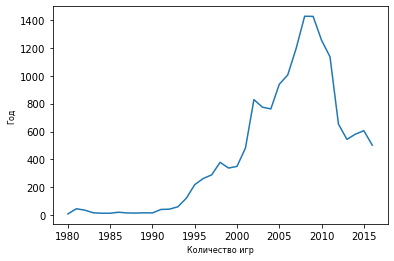

In [16]:
data['year_of_release']=data['year_of_release'].astype('int')

game_quantity_years = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
game_quantity_years.columns=['games_quantity']
display(game_quantity_years)
#game_quantity_years.plot(kind='hist', y='year_of_release')
plt.xlabel('game_quantity_years')
plt.ylabel('games_quantity')
plt.plot(game_quantity_years.index, game_quantity_years.values);

plt.xlabel('Количество игр', fontsize=8)
plt.ylabel('Год', fontsize=8)

**Выводы по 1 пункту**

Больше всего игр выпускалось в период 2004-2012 гг. При этом после 2014 года наблюдается резкий спад. В 2015 году наблюдался незначительный подъем, но все равно возврата к прежним значениям не было.

Наименьший выпуск игр производился в период до 1995 г. На мой взгляд, это логично объясняется тем, что до этого момента компьютерные игры только зарождались, и не было большого количества разработчиков.

Более того, мне кажется, что проводить анализ выпуска игр до 2013 года будет неэффективно. Для прогнозирования необходимо использовать самые свежие данные, а это данные с 2013 года (2-3 последних года, как правило).

### Анализ продаж по платформам


Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Проведем анализ, как менялись продажи по платформам. 

In [17]:
platform = data.groupby(['platform', 'year_of_release'])['sales'].agg(['sum']).reset_index().sort_values(by='sum', ascending=False)
platform.columns=['platform', 'year_of_release', 'sum_of_sales']
display(platform.head(10))

,platform,year_of_release,sum_of_sales
134,ps2,2004,211.81
197,wii,2009,206.97
132,ps2,2002,205.38
133,ps2,2003,184.31
196,wii,2008,171.32
218,x360,2010,170.03
124,ps,1998,169.49
131,ps2,2001,166.43
135,ps2,2005,160.66
147,ps3,2011,156.78


,year_of_release,sum_of_sales
130,2000,39.17
131,2001,166.43
132,2002,205.38
133,2003,184.31
134,2004,211.81
135,2005,160.66
136,2006,103.42
137,2007,75.99
138,2008,53.90
139,2009,26.40


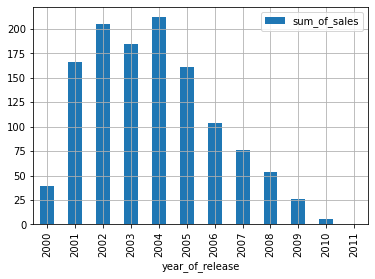

In [18]:
platform_ps2 = platform.loc[platform['platform'] == 'ps2'].sort_values(by='year_of_release', ascending=True)
platform_ps2.pop('platform')
display(platform_ps2)

platform_ps2.plot(kind='bar', x='year_of_release', y='sum_of_sales', grid=True, legend=True);

,year_of_release,sum_of_sales
194,2006,137.15
195,2007,152.77
196,2008,171.32
197,2009,206.97
198,2010,127.95
199,2011,59.65
200,2012,21.71
201,2013,8.59
202,2014,3.75
203,2015,1.14


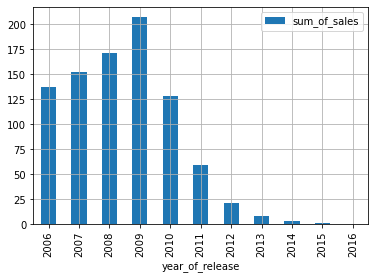

In [19]:
platform_wii = platform.loc[platform['platform'] == 'wii'].sort_values(by='year_of_release', ascending=True)
platform_wii.pop('platform')
display(platform_wii)

platform_wii.plot(kind='bar', x='year_of_release', y='sum_of_sales', grid=True, legend=True);

,year_of_release,sum_of_sales
213,2005,8.25
214,2006,51.62
215,2007,95.41
216,2008,135.26
217,2009,120.29
218,2010,170.03
219,2011,143.84
220,2012,99.74
221,2013,88.58
222,2014,34.74


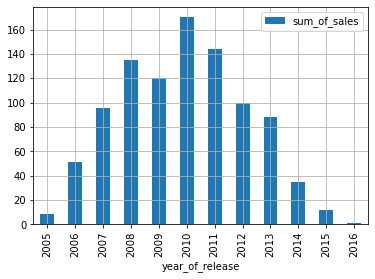

In [20]:
platform_x360 = platform.loc[platform['platform'] == 'x360'].sort_values(by='year_of_release', ascending=True)
platform_x360.pop('platform')
display(platform_x360)

platform_x360.plot(kind='bar', x='year_of_release', y='sum_of_sales', grid=True, legend=True);

**Вывод**

На основе анализа трех платформ можно сделать следующие выводы:
+ Обычный срок жизни платформы составляет 8 лет. За это время можно наблюдать все фазы жизненного цикла компании: рост, пиковые значения, спад, упадок.
+ Некоторые компании имеют "правые" и "левые" хвосты. Это значит, что в начале в конце своего жизненного цикла они имели периоды наименьшей прибыли.
+ Деятельность наиболее успешных компаний приходилась на 2006-2013 гг. +/- 3 года. К 2014 году у всех компаний наблюдался спад.
+ Компании требуется 1-2 года на "появление" и становление; 6-8 лет на активную деятельность; 1-3 года на полный спад и уход с рынка

### Анализ актуального временного промежутка

Оставим только актуальный временной промежуток: как я уже сказала ранее, на мой взгляд, это период с 2013 года. Все данные, относящиеся к годам ранее-отбросим.

+ Определим наиболее выгодные платформы
+ Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам
+ Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков


In [21]:
#Создадим датасет с актуальными данными и в дальнейшем будем использовать именно его.
data_actual = data.loc[data['year_of_release']>=2013].copy()

In [22]:
# На основе актуального датасета найдем наиболее прибыльные и самые убыточные платформы.

platform_actual = data_actual.groupby(['platform', 'year_of_release'])['sales'].agg(['sum']).reset_index().sort_values(by='sum', ascending=False)
platform_actual.columns=['platform', 'year_of_release', 'sum_of_sales']
platform_actual.sort_values(by='sum_of_sales', ascending=False)
display(platform.head(10))
display(platform_actual.tail(10))


,platform,year_of_release,sum_of_sales
134,ps2,2004,211.81
197,wii,2009,206.97
132,ps2,2002,205.38
133,ps2,2003,184.31
196,wii,2008,171.32
218,x360,2010,170.03
124,ps,1998,169.49
131,ps2,2001,166.43
135,ps2,2005,160.66
147,ps3,2011,156.78


,platform,year_of_release,sum_of_sales
23,psv,2016,4.25
25,wii,2014,3.75
12,ps3,2016,3.60
17,psp,2013,3.14
4,ds,2013,1.54
35,x360,2016,1.52
26,wii,2015,1.14
18,psp,2014,0.24
27,wii,2016,0.18
19,psp,2015,0.12


**Выводы**

Начиная с 2004 года, наиболее прибыльными были платформы:
+ ps3
+ x360
+ ps4
+ 3ds
+ ps4

Наименее прибыльными:
+ psp
+ psv
+ ps3
+ pc

#### Проанализируем продажи наиболее успешных платформ:

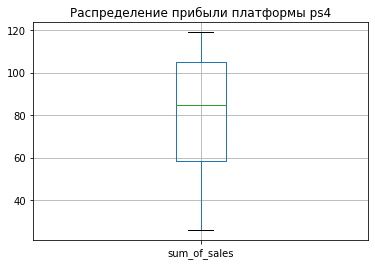

In [23]:
platform_actual.loc[platform_actual['platform']=='ps4'].boxplot(column=['sum_of_sales'])
plt.title('Распределение прибыли платформы ps4', fontsize=12);

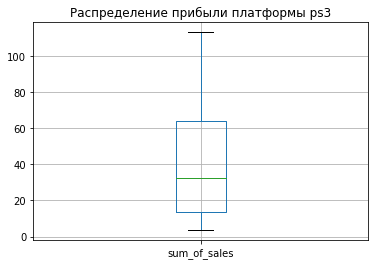

In [24]:
platform_actual.loc[platform_actual['platform']=='ps3'].boxplot(column=['sum_of_sales'])
plt.title('Распределение прибыли платформы ps3', fontsize=12);

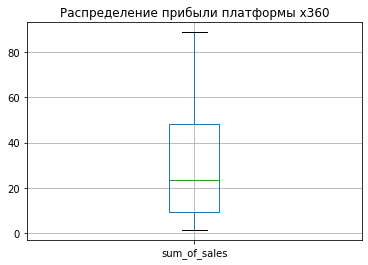

In [25]:
platform_actual.loc[platform_actual['platform']=='x360'].boxplot(column=['sum_of_sales'])
plt.title('Распределение прибыли платформы x360', fontsize=12);




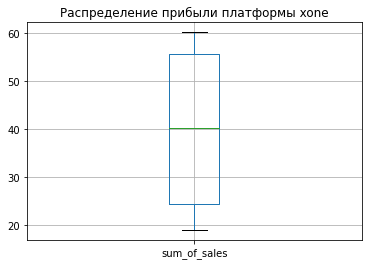

In [26]:
platform_actual.loc[platform_actual['platform']=='xone'].boxplot(column=['sum_of_sales'])
plt.title('Распределение прибыли платформы xone', fontsize=12);

**Выводы**
+ Межквартильный размах наиболее удачных платформ составляем 25-60 у.е., при этом у отдельных платформ (самых удачных 60-100).
+ Медианные значения не находятся в одном диапазоне. У части платформ медиана приближена к 25-40 у.е, у части к 80 у.е
+ В продаж на платформах отсутсвуют выбросы, что говорит о том, что нет выбивающихся показателей в продажах
+ У половины платформ имеется длинный правый ус: имеется большая вариативность объемов продаж в большую сторону от медианы.

### Изучение взаимосвязи данных:

На основе нескольких платформ попробуем посмотреть, есть взаимосвязь между оценками пользователей и критиков и продажами. 
Сделаем это на основе платформы ps3, x360.


Меняем формат данных у оценок пользователей и оценок критиков, для того, чтобы посчитать корреляцию между значениями
Пропуски оставим как nan.

In [27]:
data['user_score']=pd.to_numeric(data['user_score'], errors='coerce')
data['critic_score']=pd.to_numeric(data['critic_score'], errors='coerce')


Корреляция на основе всех данных:
Корреляция между продажи и оценкой пользователей составляет  0.08798399271321644
Корреляция между продажи и оценкой критиков составляет  0.24534884547411395


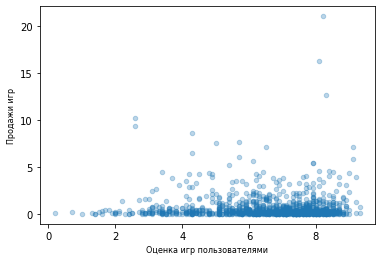

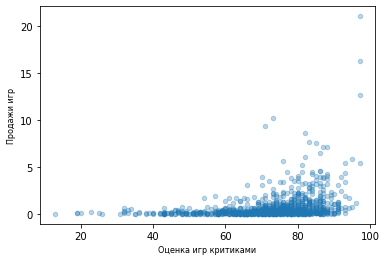

In [28]:
print("Корреляция на основе всех данных:")

data.loc[data['year_of_release'] >= 2013].plot(x='user_score', y='sales', kind='scatter', alpha=0.3) 
plt.xlabel('Оценка игр пользователями', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8)

data.loc[data['year_of_release'] >= 2013].plot(x='critic_score', y='sales', kind='scatter', alpha=0.3); 
plt.xlabel('Оценка игр критиками', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8);

print('Корреляция между продажи и оценкой пользователей составляет ',data['sales'].corr(data['user_score']))
print('Корреляция между продажи и оценкой критиков составляет ',data['sales'].corr(data['critic_score']))


Корреляция на основе  данных платформы ps3:

Корреляция между продажи и оценкой пользователей составляет 0.002394402735756684
Корреляция между продажи и оценкой критиков составляет 0.33428533933719184


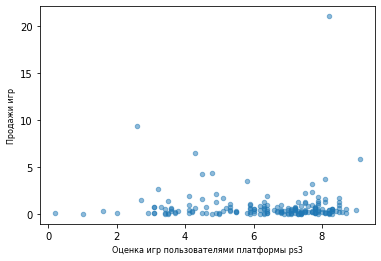

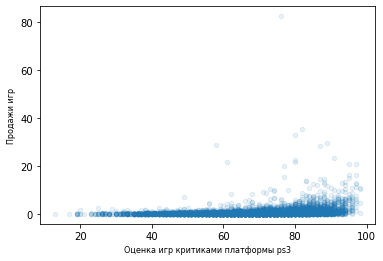

In [29]:
print("Корреляция на основе  данных платформы ps3:")
print()

data_ps3 = data.loc[data['year_of_release'] >= 2013] 
data_ps3 = data_ps3.loc[data['platform'] == 'ps3']
data_ps3.plot(x='user_score', y='sales', kind='scatter', alpha=0.5)
plt.xlabel('Оценка игр пользователями платформы ps3', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8)

data.plot(x='critic_score', y='sales', kind='scatter', alpha=0.1); 
plt.xlabel('Оценка игр критиками платформы ps3', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8);

print('Корреляция между продажи и оценкой пользователей составляет', data_ps3['sales'].corr(data_ps3['user_score']))
print('Корреляция между продажи и оценкой критиков составляет', data_ps3['sales'].corr(data_ps3['critic_score']))

Корреляция на основе  данных платформы x360:

Корреляция между продажи и оценкой пользователей составляет -0.01174218514718135
Корреляция между продажи и оценкой критиков составляет 0.3503445460228664


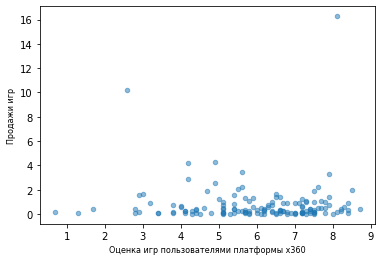

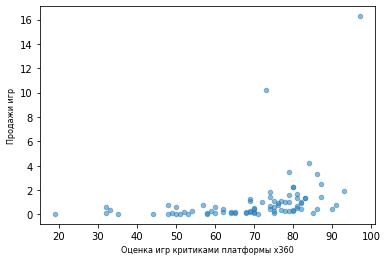

In [30]:
print("Корреляция на основе  данных платформы x360:")
print()

data_x360 = data.loc[data['year_of_release'] >= 2013] 
data_x360 = data_x360.loc[data['platform'] == 'x360']

data_x360.plot(x='user_score', y='sales', kind='scatter', alpha=0.5)
plt.xlabel('Оценка игр пользователями платформы x360', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8)


data_x360.plot(x='critic_score', y='sales', kind='scatter', alpha=0.5)
plt.xlabel('Оценка игр критиками платформы x360', fontsize=8)
plt.ylabel('Продажи игр', fontsize=8)


print('Корреляция между продажи и оценкой пользователей составляет', data_x360['sales'].corr(data_x360['user_score']))
print('Корреляция между продажи и оценкой критиков составляет', data_x360['sales'].corr(data_x360['critic_score']))

**Выводы**

Я проанализировала корреляцию между значениями оценок пользователей и продажами, между значениями оценок критиков и продажами на основе общего датасета (для актульного периода с 2013 года). Также я проанализировала корреляцию между оценками и продажами на основе двух отдельных платформ, которые подтвердили результаты, полученные на основе всего датасета. На основе этого можно сделать следующие выводы:
+ Между значениями оценок пользователей и продажами очень слабая корреляция. Иногда она даже принимает оочень маленькое отрицательное значение. Это говорит, о том что взаимосвязи между показтелями практически нет (очень слабая положительная-незначительная в данном масштабе)
+ Между значениями оценок критиков и продажами имеется довольно весомая положительная связь (от 0.2 до 0.36). Эта связь не сильная, т.к. значение меньше 0.5, но все же имеет вес. Это говорит о том, что чем выше оценка критиков, тем, как правило, выше продажи игры.
+ Также можно заметить следующие моменты:
    + Как правило, продажи игр резко возрастают при оценке пользователей больше 6
    + Как правило, продажи игр плавно возрастают, но при оценке критиков более 60-начинают более резко возрастать.
    

### Анализ взаимосвязи жанра игры и ее прибыльности

Давайте посмотрим, как взаимосвязаны между собой жанр игры и ее прибыльность. Для этого сделаем следующее:
+ Произведем отбор данных по актуальному времени (с 2013 года)
+ Построим график, на котором отразим количество игр по каждому жанру
+ Сравним медианные продажи по каждому жанру



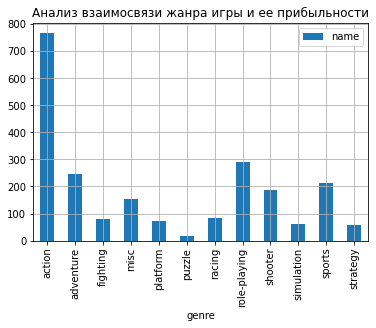

In [31]:
data_actual.groupby('genre')['name'].agg('count').plot(kind='bar', x='genre', y='count', grid=True, legend=True)
plt.title('Анализ взаимосвязи жанра игры и ее прибыльности', fontsize=12);


['sports' 'platform' 'racing' 'role-playing' 'puzzle' 'misc' 'shooter'
 'simulation' 'action' 'fighting' 'adventure' 'strategy']


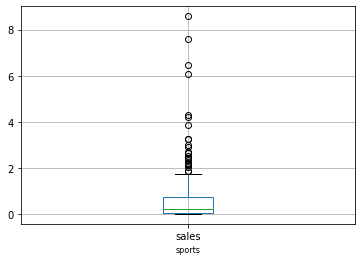

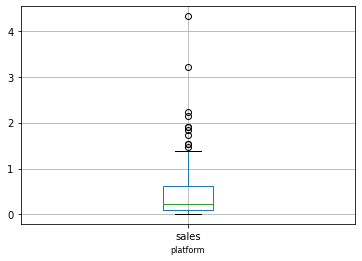

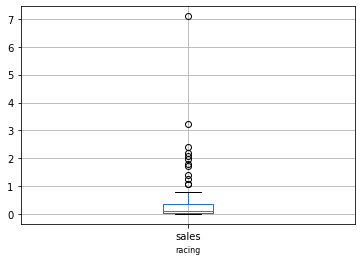

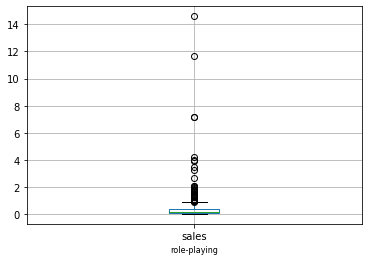

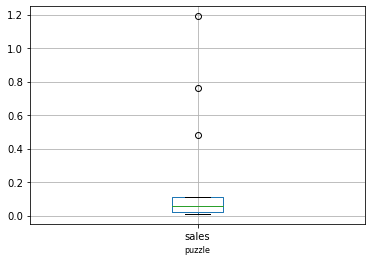

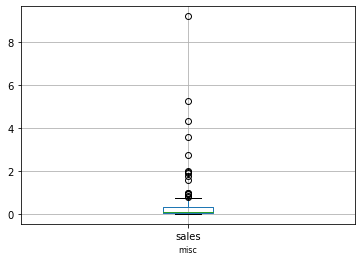

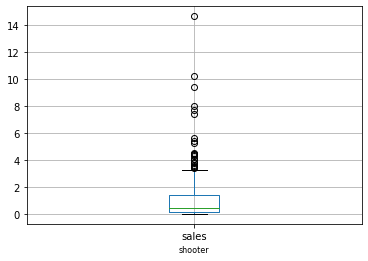

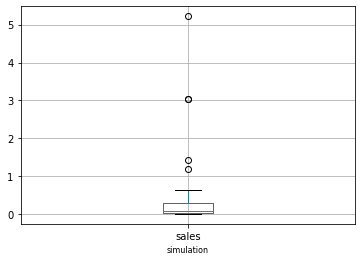

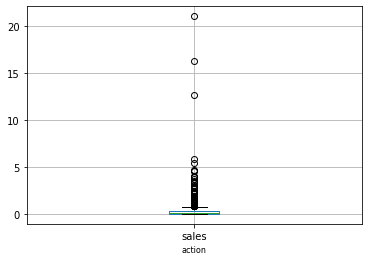

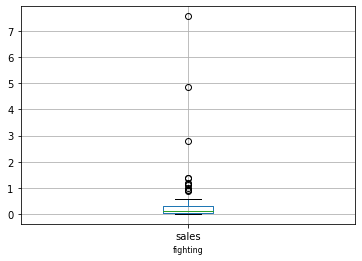

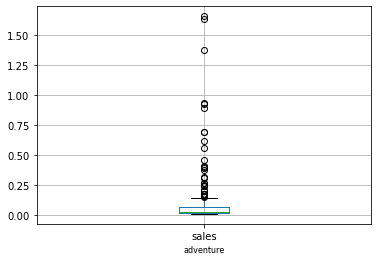

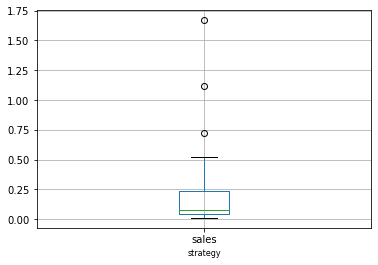

In [32]:
genre_unique = data['genre'].unique()
print(genre_unique)

for i in genre_unique:
    data_actual.loc[data_actual['genre']== i].boxplot(column=['sales'])
    plt.xlabel(i, fontsize=8)
    plt.autoscale()
    plt.show()


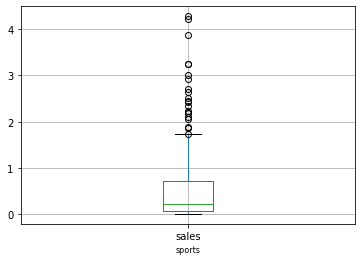

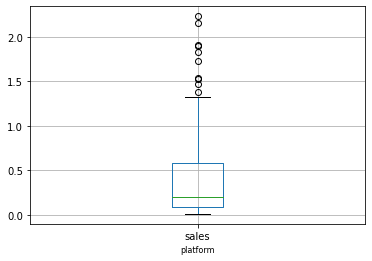

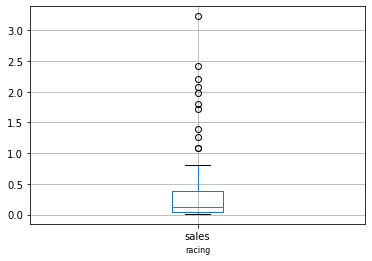

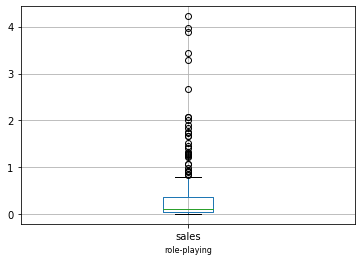

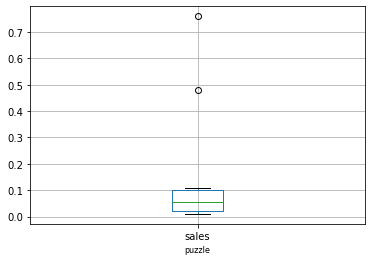

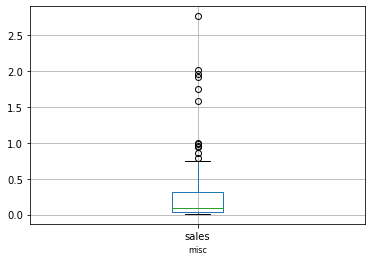

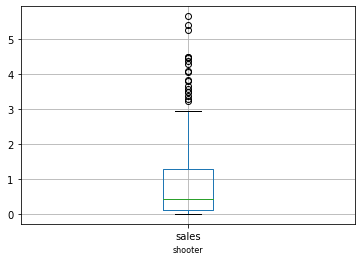

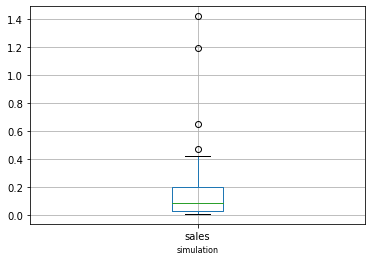

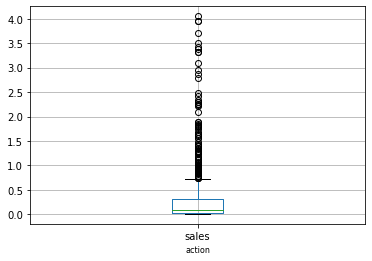

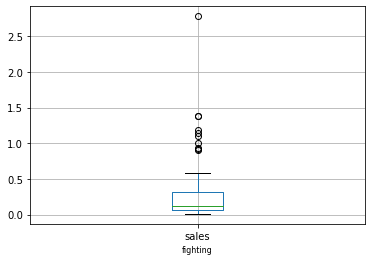

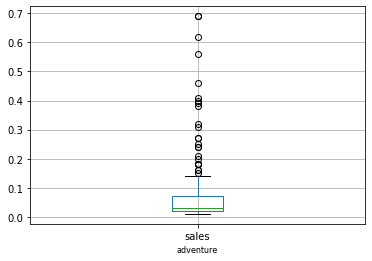

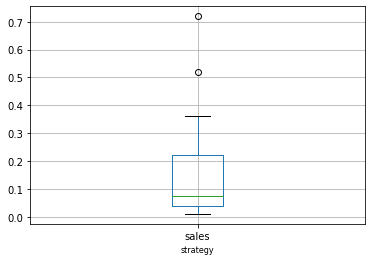

In [33]:
for i in genre_unique:
    dt=data_actual.loc[data_actual['genre']== i]
    std = np.std(dt['sales'], ddof=1)
    mean = dt['sales'].mean()
    data_top_line= mean+3*std
    
    dt.loc[dt['sales']<= data_top_line].boxplot(column=['sales'])
    plt.xlabel(i, fontsize=8)
    plt.autoscale()
    plt.show()


Числовое значение между объемами продаж и жанром нельзя найти, т.к. значение жанра является текстовым (качественный показатель), а объем продаж-количественным показателем. 

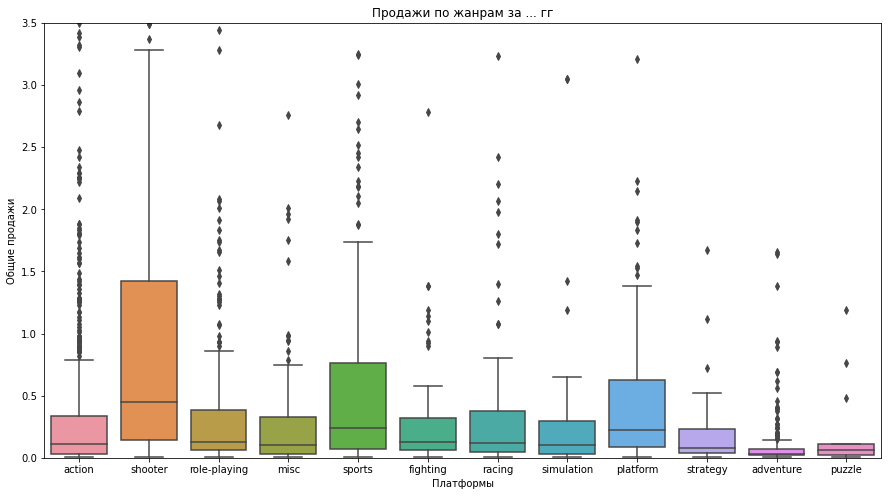

In [34]:
# check

import seaborn as sns

plt.figure(figsize=(15, 8))
(sns.boxplot(data = data_actual, y = 'sales', x='genre')
    .set(title = 'Продажи по жанрам за ... гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3.5)))

plt.show()

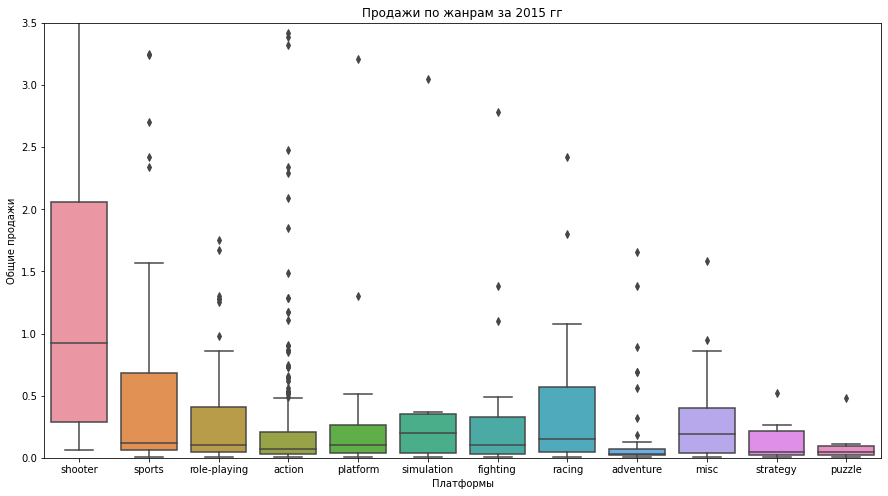

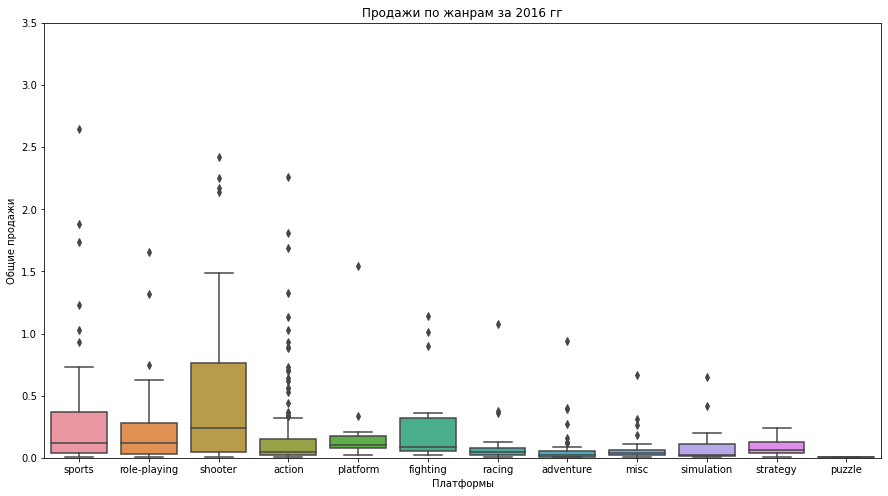

In [35]:

plt.figure(figsize=(15, 8))
(sns.boxplot(data = data_actual.loc[data_actual['year_of_release']== 2015], y = 'sales', x='genre')
    .set(title = 'Продажи по жанрам за 2015 гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3.5)))

plt.show()

plt.figure(figsize=(15, 8))
(sns.boxplot(data = data_actual.loc[data_actual['year_of_release']== 2016], y = 'sales', x='genre')
    .set(title = 'Продажи по жанрам за 2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3.5)))

plt.show()

**Вывод**

За актуальный период:

Среди жанров можно заметить следующее:
+ Наиболее популярным был жанр игры 'action'. Он имеет сильный отрыв от всех остальных жанров и явлется бесспорным лидером.
+ Наименее популярным жанром был жанр "puzzle".
+ Средние показатели по популярности показали жанры , "role-playing", "adventure","sport", "shooter".

Среди показателей по выручке среди жанров можно отметить следующее:
+ Наибольшее количество выбросов было у жанров action, role-playing как до очистки от выбросов, так и после.
+ Наименьшее количество выбросов было у жанров strategy, simulation, puzzle как до очистки от выбросов, так и после.
+ Наиболее устойчивая медиана оказалась у sports, platform, racing.
+ Наименее устойчивая медиана оказалась у misc, simulation, action.

Среди показателей по выручке при разбивке на жанры можно заметить следующее:
+ В 2015 году самым популярным жанров был shooter. В 2016 году жанр сохранил свою лидрующую позицию, хоть и снизил медианный уровень.
+ Также уверенные позиции в 2015  занимали такие жанры как: sports, racing, misc.
+ В 2016 году эти жанры "сдали" позиции и сместились на "срединные" показателями. Лидерами стали: sport и fighting. 

## Составление портрета пользователя:

На основе данных составим портреты пользователей различных регионов NA, EU, JP: 
+ Определим популярные платформы (топ-5)
+ Определеим популярные жанры (топ-5)
+ Определим влияет ли рейтинг ESRB на продажи в отдельном регионе

In [36]:
# Составим новые датафреймы

data_actual['rating']=data_actual['rating'].fillna("without rating", downcast='infer')

#display(data_actual.head(3))
#data_actual.info()

data_na = data_actual.copy()
data_na=data_na.drop(['eu_sales'], axis=1)
data_na=data_na.drop(['jp_sales'], axis=1)
data_na=data_na.drop(['other_sales'], axis=1)

data_eu = data_actual.copy()
data_eu=data_eu.drop(['na_sales'], axis=1)
data_eu=data_eu.drop(['jp_sales'], axis=1)
data_eu=data_eu.drop(['other_sales'], axis=1)

data_jp = data_actual.copy()
data_jp=data_jp.drop(['na_sales'], axis=1)
data_jp=data_jp.drop(['eu_sales'], axis=1)
data_jp=data_jp.drop(['other_sales'], axis=1);

#display(data.head(2))
#display(data_na.head(2))
#display(data_eu.head(2))
#display(data_jp.head(2))

In [37]:
# check
data_eu_copy = data_actual[['name', 'platform', 'year_of_release', 'genre', 'eu_sales', 'rating', 'sales']].copy()
data_eu_copy.head(2)

,name,platform,year_of_release,genre,eu_sales,rating,sales
16,grand theft auto v,ps3,2013,action,9.09,M,21.05
23,grand theft auto v,x360,2013,action,5.14,M,16.27


In [38]:
# check
data_na.groupby('platform')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False).head(7)

,na_sales
platform,
ps4,108.74
xone,93.12
x360,81.66
ps3,63.50
3ds,38.20
wiiu,29.21
pc,11.11


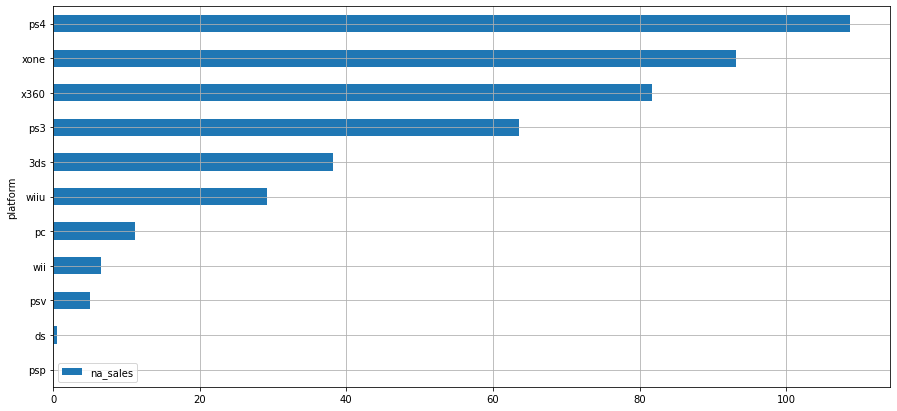

In [39]:
# check
(
    data_na.groupby('platform')['na_sales'].agg('sum')
            .to_frame().sort_values(by='na_sales', ascending=True)
            .plot(kind='barh', y='na_sales', grid=True, legend=True, figsize=(15,7))
);


In [40]:
data_na_5_platform = data_na.groupby('platform')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False)[:5]
data_na_5_platform.loc['other'] = data_na.groupby('platform')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False)[6:].sum()
data_na_5_platform

,na_sales
platform,
ps4,108.74
xone,93.12
x360,81.66
ps3,63.50
3ds,38.20
other,23.28


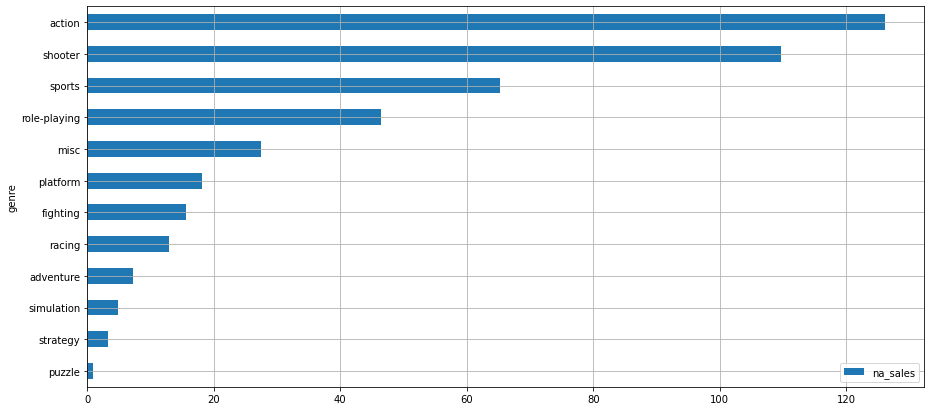

In [41]:
data_na.groupby('genre')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False).head(7)
(
    data_na.groupby('genre')['na_sales'].agg('sum')
            .to_frame().sort_values(by='na_sales', ascending=True)
            .plot(kind='barh', y='na_sales', grid=True, legend=True, figsize=(15,7))
);

In [42]:
data_na_5_genre = data_na.groupby('genre')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False)[:5]
data_na_5_genre.loc['other'] = data_na.groupby('genre')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False)[6:].sum()
data_na_5_genre

,na_sales
genre,
action,126.05
shooter,109.74
sports,65.27
role-playing,46.40
misc,27.49
other,44.62


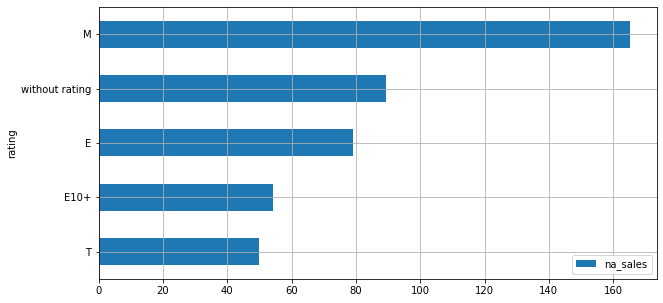

In [43]:
data_na.groupby('rating')['na_sales'].agg('sum').to_frame().sort_values(by='na_sales', ascending=False).head(7)

(
    data_na.groupby('rating')['na_sales'].agg('sum')
            .to_frame().sort_values(by='na_sales', ascending=True)
            .plot(kind='barh', y='na_sales', grid=True, legend=True, figsize=(10, 5))
);

**Выводы по североамериканскому рынку**

+ Наиболее попурлярными платформами являются: x360, ps2, wii (по убыванию). От них отстают, но также входят в 5-ку лидеров по продажам платформы: ps3, ds.
+ Наименее популярными платформами являются: dc, psv, gen, wiiu, snes.


+ Наименее популярными жанрами являются: action, sports, shooter
+ Наиболее популярными жанрами являются: puzzle, adventure, strategy.


+ Наиболее популярны игры возрастной категории М. После этого Е и Е10+. При этом игры без рейтинга занимают второе после М место по капитализации. Пользователей не смущает отсутствие рейтинга у игр. 

*Все данные указываются в порядке убывания значений. Далее-аналогично.

In [44]:
data_eu.groupby('platform')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False).head(7)

,eu_sales
platform,
ps4,141.09
ps3,67.81
xone,51.59
x360,42.52
3ds,30.96
pc,25.36
wiiu,19.85


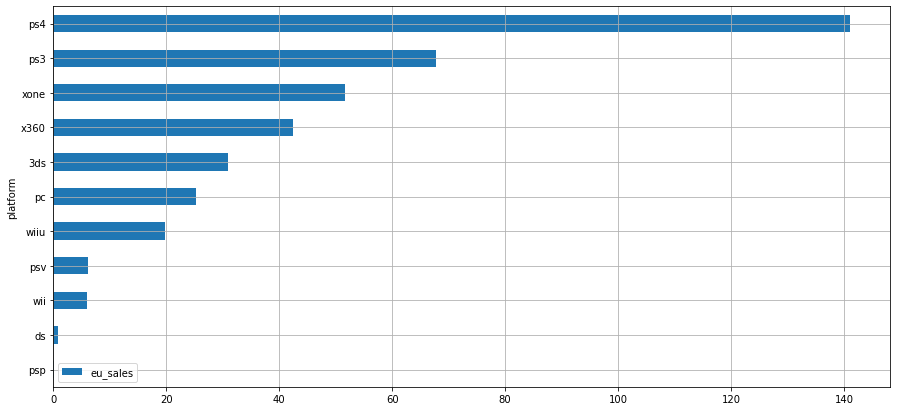

In [45]:
(
    data_eu.groupby('platform')['eu_sales'].agg('sum')
            .to_frame().sort_values(by='eu_sales', ascending=True)
            .plot(kind='barh', y='eu_sales', grid=True, legend=True, figsize=(15,7))
);


In [46]:
data_eu_5_platform = data_eu.groupby('platform')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False)[:5]
data_eu_5_platform.loc['other'] = data_eu.groupby('platform')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False)[6:].sum()
data_eu_5_platform

,eu_sales
platform,
ps4,141.09
ps3,67.81
xone,51.59
x360,42.52
3ds,30.96
other,32.90


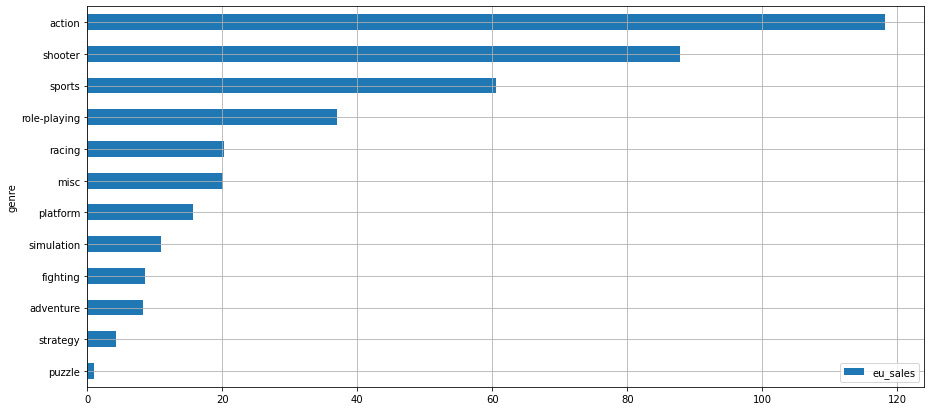

In [47]:
data_eu.groupby('genre')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False).head(7)
#data_na.groupby('genre')['na_sales'].agg('sum').plot(kind='bar', x='platform', y='genre', grid=True, legend=True)
(
    data_eu.groupby('genre')['eu_sales'].agg('sum')
            .to_frame().sort_values(by='eu_sales', ascending=True)
            .plot(kind='barh', y='eu_sales', grid=True, legend=True, figsize=(15,7))
);

In [48]:
data_eu_5_genre = data_eu.groupby('genre')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False)[:5]
data_eu_5_genre.loc['other'] = data_eu.groupby('genre')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False)[6:].sum()
data_eu_5_genre

,eu_sales
genre,
action,118.13
shooter,87.86
sports,60.52
role-playing,36.97
racing,20.19
other,48.52


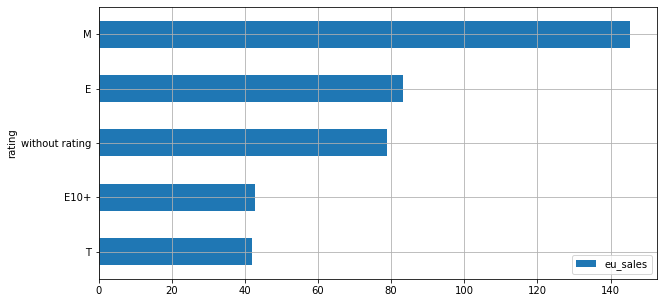

In [49]:
data_eu.groupby('rating')['eu_sales'].agg('sum').to_frame().sort_values(by='eu_sales', ascending=False).head(7)

(
    data_eu.groupby('rating')['eu_sales'].agg('sum')
            .to_frame().sort_values(by='eu_sales', ascending=True)
            .plot(kind='barh', y='eu_sales', grid=True, legend=True, figsize=(10,5))
);

**Выводы по европейскому рынку**

+ Наиболее попурлярными платформами являются: ps3, ps4, xone (по убыванию). Также высокую популярность имеют ps и ds.
+ Наименее популярными платформами являются: wii, ds, psp.


+ Наименее популярными жанрами являются: action, sports, shooter
+ Наиболее популярными жанрами являются: adventure,strategy, puzzle


+ Наиболее популярны игры возрастной категории М. После этого Е. Игры без рейтинга занимают третье место по прибыльности.


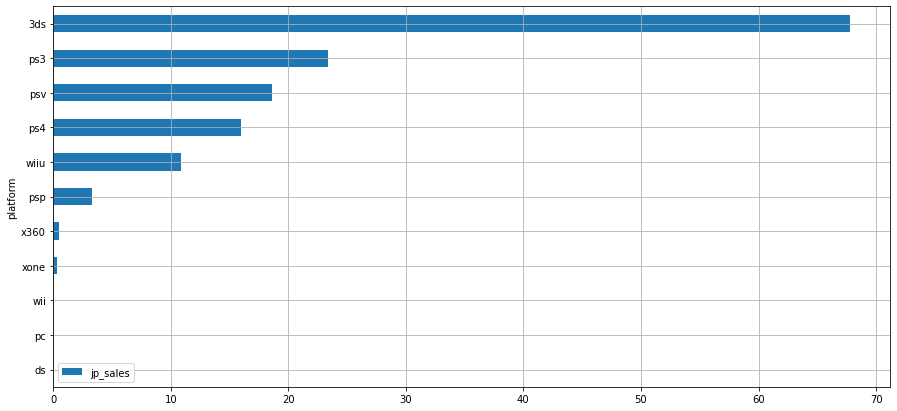

In [50]:
data_jp.groupby('platform')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False).head(7)

(
    data_jp.groupby('platform')['jp_sales'].agg('sum')
            .to_frame().sort_values(by='jp_sales', ascending=True)
            .plot(kind='barh', y='jp_sales', grid=True, legend=True, figsize=(15,7))
);

In [51]:
data_jp_5_platform = data_jp.groupby('platform')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False)[:5]
data_jp_5_platform.loc['other'] = data_jp.groupby('platform')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False)[6:].sum()
data_jp_5_platform

,jp_sales
platform,
3ds,67.81
ps3,23.35
psv,18.59
ps4,15.96
wiiu,10.88
other,0.90


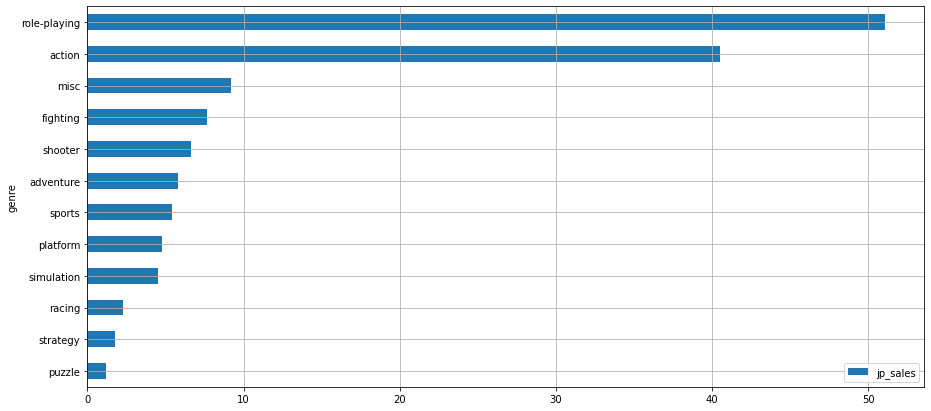

In [52]:
data_jp.groupby('genre')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False).head(7)

(
    data_jp.groupby('genre')['jp_sales'].agg('sum')
            .to_frame().sort_values(by='jp_sales', ascending=True)
            .plot(kind='barh', y='jp_sales', grid=True, legend=True, figsize=(15,7))
);

In [53]:
data_jp_5_genre = data_jp.groupby('genre')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False)[:5]
data_jp_5_genre.loc['other'] = data_jp.groupby('genre')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False)[6:].sum()
data_jp_5_genre

,jp_sales
genre,
role-playing,51.04
action,40.49
misc,9.20
fighting,7.65
shooter,6.61
other,19.97


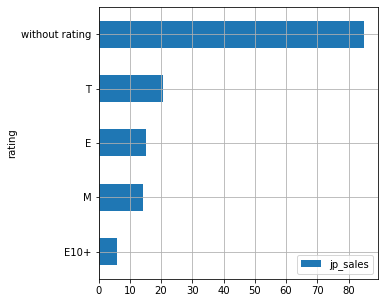

In [54]:
data_jp.groupby('rating')['jp_sales'].agg('sum').to_frame().sort_values(by='jp_sales', ascending=False).head(7)

(
    data_jp.groupby('rating')['jp_sales'].agg('sum')
            .to_frame().sort_values(by='jp_sales', ascending=True)
            .plot(kind='barh', y='jp_sales', grid=True, legend=True, figsize=(5, 5))
);

**Выводы по японскому рынку**

+ Наиболее попурлярными платформами являются: 3ds, ps3, psv. 
+ Наименее популярными платформами являются: wii, pc, ds.


+ Наиболее популярными жанрами являются: arole-playing(беспорный лидер), action, misc.
+ Наименее популярными жанрами являются: racing, strategy, puzzle 


+ Наиболее популярны игры без рейтинга и они составляют абсолютное большинство продаж на рынке. После этого игры с рейтингами Т и Е.


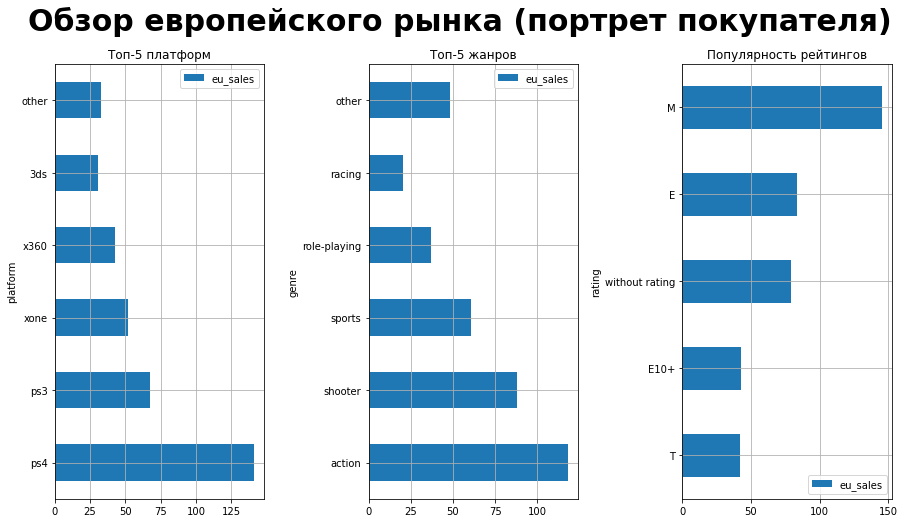

In [66]:
# check

fig, ax = plt.subplots(1,3, figsize=(15, 8))

fig.suptitle('Обзор европейского рынка (портрет покупателя)', fontsize = 30, fontweight='bold')

data_eu_5_platform.plot(kind='barh', y='eu_sales', grid=True, legend=True,  ax = ax[0]).set_title('Топ-5 платформ')
data_eu_5_genre.plot(kind='barh', y='eu_sales', grid=True, legend=True, ax = ax[1]).set_title('Топ-5 жанров')
(
    data_eu.groupby('rating')['eu_sales'].agg('sum')
            .to_frame().sort_values(by='eu_sales', ascending=True)
            .plot(kind='barh', y='eu_sales', grid=True, legend=True, ax = ax[2])
            .set_title('Популярность рейтингов')
)

plt.subplots_adjust(wspace=0.5);


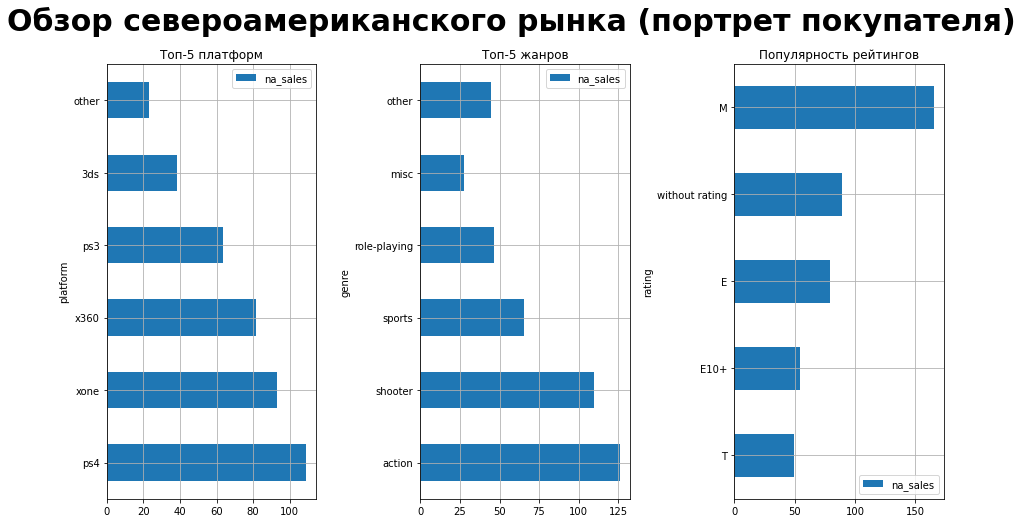

In [56]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))

fig.suptitle('Обзор североамериканского рынка (портрет покупателя)', fontsize = 30, fontweight='bold')

data_na_5_platform.plot(kind='barh', y='na_sales', grid=True, legend=True, ax = ax[0]).set_title('Топ-5 платформ')
data_na_5_genre.plot(kind='barh', y='na_sales', grid=True, legend=True, ax = ax[1]).set_title('Топ-5 жанров')
(
    data_na.groupby('rating')['na_sales'].agg('sum')
            .to_frame().sort_values(by='na_sales', ascending=True)
            .plot(kind='barh', y='na_sales', grid=True, legend=True, ax = ax[2])
            .set_title('Популярность рейтингов')
)

plt.subplots_adjust(wspace=0.5);


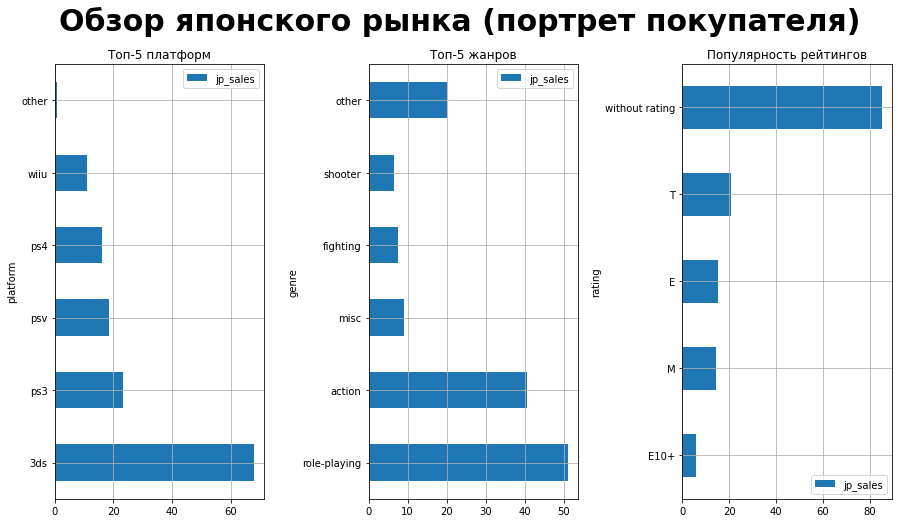

In [57]:
fig, ax = plt.subplots(1,3, figsize=(15, 8))

fig.suptitle('Обзор японского рынка (портрет покупателя)', fontsize = 30, fontweight='bold')

data_jp_5_platform.plot(kind='barh', y='jp_sales', grid=True, legend=True, ax = ax[0]).set_title('Топ-5 платформ')
data_jp_5_genre.plot(kind='barh', y='jp_sales', grid=True, legend=True, ax = ax[1]).set_title('Топ-5 жанров')
(
    data_jp.groupby('rating')['jp_sales'].agg('sum')
            .to_frame().sort_values(by='jp_sales', ascending=True)
            .plot(kind='barh', y='jp_sales', grid=True, legend=True, ax = ax[2])
            .set_title('Популярность рейтингов')
)

plt.subplots_adjust(wspace=0.5);

## Проверка гипотез

На основе полученных и обработанных данных проверим следующие гипотезы:
+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
+ Средние пользовательские рейтинги жанров Action и Sports разные.

### Проверка первой гипотезы:

+ Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;


H0-средний пользовательский рейтинг платформы Xbox One

Н1-средний пользовательский рейтинг платформы PC

0: H0 = H1

1: H0 != H1

Гипотеза двухстронняя, потому нам нам настолько важно, в какую именно сторону может отклоняться среднее.

Гипотезы будем проверять как средние двух генеральных совокупностей. Мы не можем взять данные выборки по рейтингам как взаимозависимые, т.к. выбор той или иной платформы не оказывает никакого влияния на других клиентов.

Уровень значимости возьмем в 5 %, т.к. разброс пользовательских оценок не такой большой. 

In [58]:
data_actual = data_actual.dropna(subset=['user_score', 'critic_score']) 
data_actual.isna().sum()


name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
sales              0
dtype: int64

In [59]:
data['user_score']=data['user_score'].astype('float64')
data_actual['user_score']=data_actual['user_score'].astype('float64')
data.info()
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  sales            16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 16 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           ---------

In [60]:
print(data_actual['platform'].unique())

['ps3' 'x360' 'ps4' 'wiiu' 'xone' '3ds' 'pc' 'psv' 'psp']


In [61]:
data_hipo_pc = data_actual.loc[data_actual['platform']== 'pc']
#data_hipo_pc = data_actual.query('platform == "pc"')
data_hipo_xb = data_actual.loc[data_actual['platform']== 'x360']
#data_hipo_xb = data_actual.query('platform == "xb"')

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data_hipo_xb['user_score'], 
    data_hipo_pc['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.9971969845258141
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Значение p-value показывает: вероятность случайно получить такое или большее различие равно почти 10%, при уровне значимости 5%. 

У нас не получается отвергнуть нулевую гипотезу, а это значит, что с определенной долей вероятности средние значения пользовательских оценок платформ Xbox One и PC одинаковые.

In [62]:
# check
data_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 16 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             976 non-null    object 
 1   platform         976 non-null    object 
 2   year_of_release  976 non-null    int32  
 3   genre            976 non-null    object 
 4   na_sales         976 non-null    float64
 5   eu_sales         976 non-null    float64
 6   jp_sales         976 non-null    float64
 7   other_sales      976 non-null    float64
 8   critic_score     976 non-null    float64
 9   user_score       976 non-null    float64
 10  rating           976 non-null    object 
 11  sales            976 non-null    float64
dtypes: float64(7), int32(1), object(4)
memory usage: 95.3+ KB


In [63]:
# check
data_hipo_xb

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
60,call of duty: ghosts,x360,2013,shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
271,fifa 14,x360,2013,sports,0.92,2.89,0.01,0.40,84.0,4.2,E,4.22
380,battlefield 4,x360,2013,shooter,2.15,1.01,0.02,0.31,79.0,5.6,M,3.49
410,assassin's creed iv: black flag,x360,2013,action,1.90,1.11,0.01,0.29,86.0,7.9,M,3.31
...,...,...,...,...,...,...,...,...,...,...,...,...
12751,tropico 5,x360,2014,simulation,0.03,0.02,0.00,0.00,71.0,7.2,T,0.05
12822,ride to hell,x360,2013,racing,0.04,0.01,0.00,0.01,19.0,1.3,M,0.06
13059,sacred 3,x360,2014,role-playing,0.03,0.02,0.00,0.00,51.0,4.1,M,0.05
13414,yaiba: ninja gaiden z,x360,2014,action,0.03,0.01,0.00,0.00,50.0,5.3,M,0.04


**Вывод**

Значение p-value показывает: вероятность случайно получить такое или большее различие равно почти 13%, хотя средние рейтинги разных платформ не одинаковы. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними рейтингами.

### Проверка второй гипотезы

+ Средние пользовательские рейтинги жанров Action и Sports разные.

H0-средний пользовательский рейтинг жанра Action 

Н1-средний пользовательский рейтинг жанра Sports

0: H0 = H1

1: H0 != H1

Гипотеза двухстронняя, потому нам нам настолько важно, в какую именно сторону может отклоняться среднее.

Гипотезы будем проверять как средние двух генеральных совокупностей. Мы не можем взять данные выборки по рейтингам как взаимозависимые, т.к. выбор того или иного жанра не оказывает никакого влияния на других клиентов.

Уровень значимости возьмем в 5 %, т.к. разброс пользовательских оценок не такой большой. 

In [64]:
# Проверка гипотезы
# Проверка второй гипотезы:
#data_actual.info()
data_hipo_action = data_actual.loc[data['genre']== 'action']
data_hipo_sports = data_actual.loc[data['genre']== 'sports']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    data_hipo_action['user_score'], 
    data_hipo_sports['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.684099430689953e-16
Отвергаем нулевую гипотезу


**Вывод**

Значение p-value показывает: вероятность случайно получить такое или большее различие равно 4.362041011712865e-09 (ничтожно мало). Значит средние рейтинги двух жанров действительно не равны.


**Вывод**

Средние пользовательские рейтинги жанров action и sports действительно одинаковые. Это значит, что в среднем пользователи ставят одинаковую оценку двум этим жанрам.

# Выводы:

В ходе выполнения работы мы сделали следующее:
+ Преобразовали данные для удобной работы с ним
+ Обраюотали дубликаты, пропуски
+ Провели иссдедовательский анализ данных
+ Провели анализ пользователя каждого региона

На основе работы можно сделать следующие выводы:

**Выводы по выпуску игр на основе представленного временного промежутка** 
+ Больше всего игр выпускалось в период 2004-2012 гг. При этом после 2014 года наблюдается резкий спад. В 2015 году наблюдался незначительный подъем, но все равно возврата к прежним значениям не было.
+ Наименьший выпуск игр производился в период до 1995 г. На мой взгляд, это логично объясняется тем, что до этого момента компьютерные игры только зарождались, и не было большого количества разработчиков.
+ Более того, мне кажется, что проводить анализ выпуска игр до 2013 года будет неэффективно. Для прогнозирования необходимо использовать самые свежие данные, а это данные с 2013 года (2-3 последних года, как правило).


**Выводы относительно работы отдельно взятой платформы**
+ Обычный срок жизни платформы составляет 8 лет. За это время можно наблюдать все фазы жизненного цикла компании: рост, пиковые значения, спад, упадок.
+ Некоторые компании имеют "правые" и "левые" хвосты. Это значит, что в начале в конце своего жизненного цикла они имели периоды наименьшей прибыли.
+ Деятельность наиболее успешных компаний приходилась на 2006-2013 гг. +/- 3 года. К 2014 году у всех компаний наблюдался спад.
+ Компании требуется 1-2 года на "появление" и становление; 6-8 лет на активную деятельность; 1-3 года на полный спад и уход с рынка


**Анализ всех данных**

Начиная с 2004 года, наиболее прибыльными были платформы:
+ ps3
+ x360
+ ps4
+ 3ds
+ ps4

Наименее прибыльными:
+ psp
+ psv
+ ps3
+ pc

### Анализ актуального временного промежутка
**Продажи наиболее популярных платформ**
+ Межквартильный размах наиболее удачных платформ составляем 25-60 у.е., при этом у отдельных платформ (самых удачных 60-100).
+ Медианные значения не находятся в одном диапазоне. У части платформ медиана приближена к 25-40 у.е, у части к 80 у.е
+ В продаж на платформах отсутсвуют выбросы, что говорит о том, что нет выбивающихся показателей в продажах
+ У половины платформ имеется длинный правый ус: имеется большая вариативность объемов продаж в большую сторону от медианы.


**Анализ взаимосвязи данных**
+ Между значениями оценок пользователей и продажами очень слабая корреляция. Иногда она даже принимает оочень маленькое отрицательное значение. Это говорит, о том что взаимосвязи между показтелями практически нет (очень слабая положительная-незначительная в данном масштабе)
+ Между значениями оценок критиков и продажами имеется довольно весомая положительная связь (от 0.2 до 0.36). Эта связь не сильная, т.к. значение меньше 0.5, но все же имеет вес. Это говорит о том, что чем выше оценка критиков, тем, как правило, выше продажи игры.
+ Также можно заметить следующие моменты:
    + Как правило, продажи игр резко возрастают при оценке пользователей больше 6
    + Как правило, продажи игр плавно возрастают, но при оценке критиков более 60-начинают более резко возрастать.

**Анализ взаимосвязи жанра игры и ее прибыльности**

За актуальный период:

Среди жанров можно заметить следующее:
+ Наиболее популярным был жанр игры 'action'. Он имеет сильный отрыв от всех остальных жанров и явлется бесспорным лидером.
+ Наименее популярным жанром был жанр "puzzle".
+ Средние показатели по популярности показали жанры , "role-playing", "adventure","sport", "shooter".

Среди показателей по выручке среди жанров можно отметить следующее:
+ Наибольшее количество выбросов было у жанров action, role-playing как до очистки от выбросов, так и после.
+ Наименьшее количество выбросов было у жанров strategy, simulation, puzzle как до очистки от выбросов, так и после.
+ Наиболее устойчивая медиана оказалась у sports, platform, racing.
+ Наименее устойчивая медиана оказалась у misc, simulation, action.

Среди показателей по выручке при разбивке на жанры можно заметить следующее:
+ В 2015 году самым популярным жанров был shooter. В 2016 году жанр сохранил свою лидрующую позицию, хоть и снизил медианный уровень.
+ Также уверенные позиции в 2015  занимали такие жанры как: sports, racing, misc.
+ В 2016 году эти жанры "сдали" позиции и сместились на "срединные" показателями. Лидерами стали: sport и fighting. 

#### Анализ отдельных рынков:

**Выводы по североамериканскому рынку**
+ Наиболее попурлярными платформами являются: x360, ps2, wii (по убыванию). От них отстают, но также входят в 5-ку лидеров по продажам платформы: ps3, ds.
+ Наименее популярными платформами являются: dc, psv, gen, wiiu, snes.


+ Наименее популярными жанрами являются: action, sports, shooter
+ Наиболее популярными жанрами являются: puzzle, adventure, strategy.


+ Наиболее популярны игры возрастной категории М. После этого Е и Е10+. При этом игры без рейтинга занимают второе после М место по капитализации. Пользователей не смущает отсутствие рейтинга у игр. 

*Все данные указываются в порядке убывания значений. Далее-аналогично.


**Выводы по европейскому рынку**
+ Наиболее попурлярными платформами являются: ps3, ps4, xone (по убыванию). Также высокую популярность имеют ps и ds.
+ Наименее популярными платформами являются: wii, ds, psp.


+ Наименее популярными жанрами являются: action, sports, shooter
+ Наиболее популярными жанрами являются: adventure,strategy, puzzle


+ Наиболее популярны игры возрастной категории М. После этого Е. Игры без рейтинга занимают третье место по прибыльности.


**Выводы по японскому рынку**
+ Наиболее попурлярными платформами являются: 3ds, ps3, psv. 
+ Наименее популярными платформами являются: wii, pc, ds.


+ Наиболее популярными жанрами являются: arole-playing(беспорный лидер), action, misc.
+ Наименее популярными жанрами являются: racing, strategy, puzzle 


+ Наиболее популярны игры без рейтинга и они составляют абсолютное большинство продаж на рынке. После этого игры с рейтингами Т и Е.

**Выводы по равенству средних**
+ У нас не получается отвергнуть нулевую гипотезу, а это значит, что с определенной долей вероятности средние значения пользовательских оценок платформ Xbox One и PC одинаковые. (гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые)
+ Значение p-value показывает: вероятность случайно получить такое или большее различие равно 4.362041011712865e-09 (ничтожно мало). Значит средние рейтинги двух жанров Action и Sports действительно не равны. (гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные)